# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
TODO

### Baseline Model
TODO

### Final Model
TODO

### Fairness Evaluation
TODO

# Code

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
import fuzzywuzzy.process as fwp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [5]:
def merge_parties(path_cand='./data/house_candidate.csv', path_trans='./data/all_transactions.csv'):
    data_candidates = pd.read_csv(path_cand)
    data_candidates["candidate"] = data_candidates["candidate"].str.lower()
    data_transactions = pd.read_csv(path_trans)
    data_transactions["representative"] = data_transactions["representative"]\
        .str.lower()\
        .str.replace("hon. ", "", regex=False)
    data_transactions["amount"] = data_transactions["amount"]\
        .str.replace("$", "", regex=False)\
        .str.replace(" ", "", regex=False)\
        .str.replace(",", "", regex=False)\
        .str.split("-")\
        .apply(lambda x : np.floor(pd.to_numeric(pd.Series(x), errors="coerce").mean()))
    data_transactions.loc[data_transactions["ticker"] == "--", "ticker"] = np.NaN
    choices = data_transactions["representative"].unique().tolist()
    data_candidates["representative"] = data_candidates["candidate"].apply(lambda x : fmatch(x, choices))
    data_candidates = data_candidates[["representative", "party"]].drop_duplicates().dropna()
    data_candidates = remove_duplicate_name(data_candidates)
    data_transactions = data_transactions[["transaction_date", "ticker", "type", "amount", "representative"]]\
        .drop_duplicates()
    return data_transactions.merge(data_candidates, how="left", left_on="representative", right_on="representative")

def fmatch(row, choices):
    choice = fwp.extractOne(row, choices, scorer=fuzz.token_set_ratio, score_cutoff=81)
    return np.NaN if choice is None else choice[0]

def count_names(search, list):
    return len(list[list["representative"] == search]) if not search == np.NaN else np.NaN

def remove_duplicate_name(df):
    new_df = df.copy()
    unique_names = pd.DataFrame(new_df["representative"]
                                .apply(lambda x : x if count_names(x, new_df) == 1 else np.NaN).dropna())
    return unique_names.merge(df, how="left", left_on="representative", right_on="representative", suffixes=("l", "r"))

In [8]:
data = merge_parties()
data.head(10)

,transaction_date,ticker,type,amount,representative,party
0,2021-09-27,BP,purchase,8000.0,virginia foxx,REP
1,2021-09-13,XOM,purchase,8000.0,virginia foxx,REP
2,2021-09-10,ILPT,purchase,32500.0,virginia foxx,REP
3,2021-09-28,PM,purchase,32500.0,virginia foxx,REP
4,2021-09-17,BLK,sale_partial,8000.0,alan s. lowenthal,DEM
5,2021-12-01,AXP,purchase,8000.0,aston donald mceachin,DEM
6,2021-11-30,KPLTW,purchase,8000.0,austin scott,REP
7,2021-11-18,AMD,sale_full,75000.0,thomas suozzi,DEM
8,2021-11-18,AAPL,sale_full,75000.0,thomas suozzi,DEM
9,2021-11-24,MSFT,purchase,75000.0,thomas suozzi,DEM


In [27]:
apple_stocks = data[data["ticker"] == "AAPL"]
apple_stocks = apple_stocks.dropna()
apple_stocks

,transaction_date,ticker,type,amount,representative,party
8,2021-11-18,AAPL,sale_full,75000.0,thomas suozzi,DEM
224,2020-07-22,AAPL,sale_partial,8000.0,lloyd k. smucker,REP
225,2020-10-09,AAPL,sale_partial,32500.0,lloyd k. smucker,REP
426,2022-02-23,AAPL,purchase,8000.0,pete sessions,REP
446,2020-08-28,AAPL,sale_partial,32500.0,david b. mckinley,REP
...,...,...,...,...,...,...
14246,2020-04-20,AAPL,sale_partial,8000.0,josh gottheimer,DEM
14366,2020-03-23,AAPL,sale_partial,75000.0,david b. mckinley,REP
14367,2020-03-09,AAPL,purchase,8000.0,david b. mckinley,REP
14392,2020-05-18,AAPL,sale_full,32500.0,josh gottheimer,DEM


### Baseline Model

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(apple_stocks[['type', 'amount', 'transaction_date']],
                                                        apple_stocks[['party']])

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier
year_prefix_hotencode = Pipeline([
("get-year", FunctionTransformer(lambda x : pd.DataFrame(x["transaction_date"].str[:4]))),
("onehot", OneHotEncoder(handle_unknown='ignore')),
])

preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type"]),
    ('year', year_prefix_hotencode, ["transaction_date"])
]
)
pl = Pipeline([
('preproc', preproc),
('embedding', DecisionTreeClassifier()),
])
pl.fit(X_train, y_train["party"])
pl.score(X_test, y_test["party"])

0.7058823529411765

In [55]:
(pl.score(X_train, y_train["party"]), pl.score(X_test, y_test["party"]))

(0.83, 0.6764705882352942)

0.7014705882352942

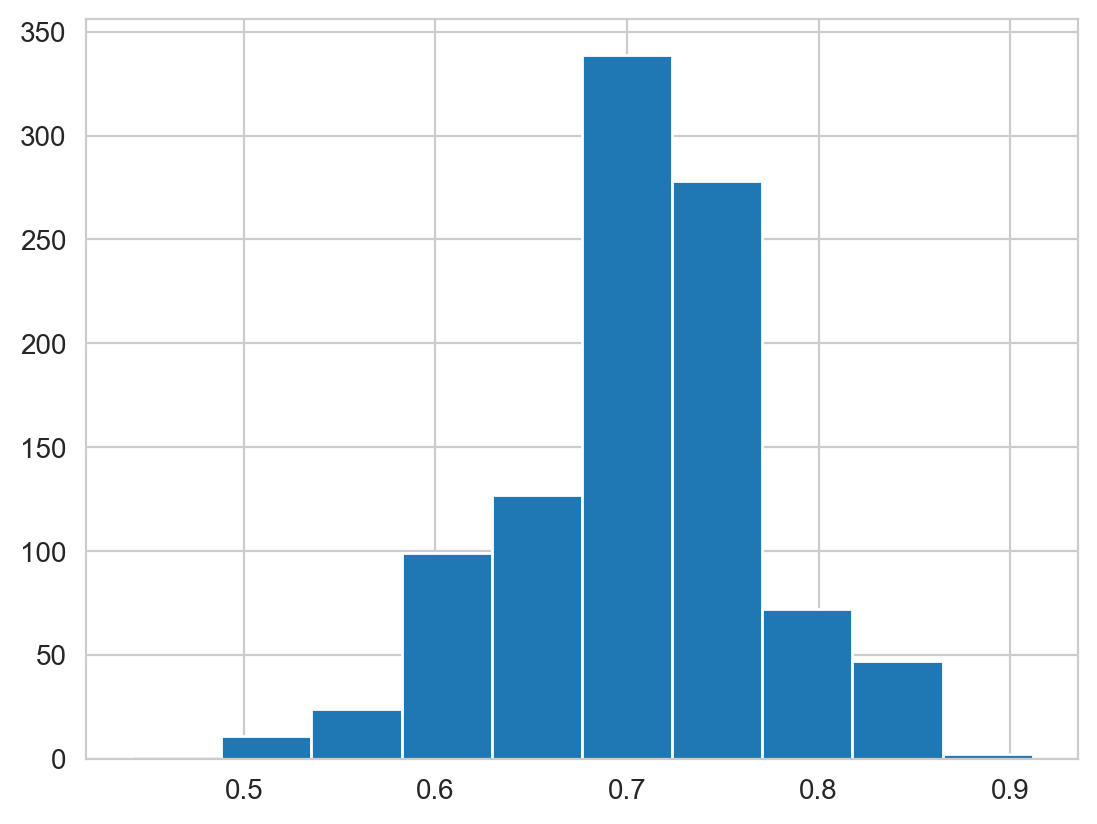

In [52]:
res = []
for _ in range(1_000):
    X_train, X_test, y_train, y_test = train_test_split(apple_stocks[['type', 'amount', 'transaction_date']],
                                                        apple_stocks[['party']])
    pl.fit(X_train, y_train["party"])
    res.append(pl.score(X_test, y_test["party"]))
pd.Series(res).hist()
pd.Series(res).mean()

In [30]:
y_train

,party
9675,DEM
4834,REP
2477,REP
12959,NaN
12756,DEM
...,...
905,REP
5192,DEM
12172,DEM
235,DEM


### Final Model

In [ ]:
# TODO

### Fairness Evaluation

In [ ]:
# TODO